In [ ]:
# The MIT License (MIT)

# Copyright (c) 2020, NVIDIA CORPORATION.

# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE

# Tutorial: Feature Engineering for Recommender Systems

# 3. Feature Engineering - Categorical

## 3.3. Target Encoding

In [1]:
import IPython

import pandas as pd
import cudf
import numpy as np
import cupy
import matplotlib.pyplot as plt

df_train = cudf.read_parquet('../data/train.parquet')
df_valid = cudf.read_parquet('../data/valid.parquet')
df_test = cudf.read_parquet('../data/test.parquet')

df_train['brand'] = df_train['brand'].fillna('UNKNOWN')
df_valid['brand'] = df_valid['brand'].fillna('UNKNOWN')
df_test['brand'] = df_test['brand'].fillna('UNKNOWN')
df_train['cat_2'] = df_train['cat_2'].fillna('UNKNOWN')
df_valid['cat_2'] = df_valid['cat_2'].fillna('UNKNOWN')
df_test['cat_2'] = df_test['cat_2'].fillna('UNKNOWN')

In [2]:
df_train.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,cat_2,cat_3,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year
0,2019-12-01 00:00:28 UTC,cart,17800342,zeta,66.90,550465671,22650a62-2d9c-4151-9f41-2674ec6d32d5,0,computers,desktop,UNKNOWN,<NA>,2019-12-01 00:00:28,0,0,6,1,12,2019
1,2019-12-01 00:00:39 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,vacuum,<NA>,2019-12-01 00:00:39,0,0,6,1,12,2019
2,2019-12-01 00:00:40 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,vacuum,<NA>,2019-12-01 00:00:40,0,0,6,1,12,2019
3,2019-12-01 00:00:41 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,vacuum,<NA>,2019-12-01 00:00:41,0,0,6,1,12,2019
4,2019-12-01 00:01:56 UTC,cart,1004767,samsung,235.60,579970209,c6946211-ce70-4228-95ce-fd7fccdde63c,0,construction,tools,light,<NA>,2019-12-01 00:01:56,0,1,6,1,12,2019


In [3]:
cat = 'brand'

## Theory

<b>*Target Encoding (TE)*</b> calculates the statistics from a target variable grouped by the unique values of one or more categorical features.<br><br>
For example in a binary classification problem, it calculates the probability that the target is true for each category value - a simple mean.

In [4]:
te = df_train[[cat, 'target']].groupby(cat).mean()

In [5]:
te

,target
brand,
UNKNOWN,0.301577
a-case,0.264910
a-derma,0.150442
a-elita,0.275862
a-mega,0.340426
...,...
zuru,0.285714
zvezda,0.444444
zwilling,0.000000


In [6]:
te = te.reset_index()
te.columns = [cat, 'TE_' + cat]
df_train.merge(te, how='left', on=cat)

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,cat_2,cat_3,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,TE_brand
0,2019-12-01 12:27:02 UTC,cart,12700214,UNKNOWN,35.38,580243411,0cbf5e06-a782-4c74-8002-acf282026d82,0,<NA>,<NA>,UNKNOWN,<NA>,2019-12-01 12:27:02,12,27,6,1,12,2019,0.301577
1,2019-12-01 12:27:02 UTC,cart,12700214,UNKNOWN,35.38,580243411,0cbf5e06-a782-4c74-8002-acf282026d82,0,<NA>,<NA>,UNKNOWN,<NA>,2019-12-01 12:27:02,12,27,6,1,12,2019,0.301577
2,2019-12-01 12:27:02 UTC,cart,12700214,UNKNOWN,35.38,580243411,0cbf5e06-a782-4c74-8002-acf282026d82,0,<NA>,<NA>,UNKNOWN,<NA>,2019-12-01 12:27:02,12,27,6,1,12,2019,0.301577
3,2019-12-01 12:27:02 UTC,cart,12700214,UNKNOWN,35.38,580243411,0cbf5e06-a782-4c74-8002-acf282026d82,0,<NA>,<NA>,UNKNOWN,<NA>,2019-12-01 12:27:02,12,27,6,1,12,2019,0.301577
4,2019-12-01 12:27:02 UTC,cart,12700214,UNKNOWN,35.38,580243411,0cbf5e06-a782-4c74-8002-acf282026d82,0,<NA>,<NA>,UNKNOWN,<NA>,2019-12-01 12:27:02,12,27,6,1,12,2019,0.301577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11461352,2019-11-30 19:09:17 UTC,purchase,1004856,samsung,124.11,514132559,56cf6962-e2bf-4d31-a45a-7b87257b0b2a,1,electronics,smartphone,UNKNOWN,<NA>,2019-11-30 19:09:17,19,9,5,30,11,2019,0.439618
11461353,2019-11-30 19:09:19 UTC,purchase,4804056,apple,160.87,522760118,772f04a5-80c2-4d15-99ce-0eb45a26b384,1,electronics,audio,headphone,<NA>,2019-11-30 19:09:19,19,9,5,30,11,2019,0.421482
11461354,2019-11-30 19:09:21 UTC,purchase,12711507,tunga,45.56,512586698,d8d092e4-d7c0-42ed-ac2b-783020d509db,1,<NA>,<NA>,UNKNOWN,<NA>,2019-11-30 19:09:21,19,9,5,30,11,2019,0.210910
11461355,2019-11-30 19:09:24 UTC,purchase,4803976,samsung,123.22,572105640,222dd50e-42ef-40da-93d2-679944ae9921,1,electronics,audio,headphone,<NA>,2019-11-30 19:09:24,19,9,5,30,11,2019,0.439618


Similarly, we can apply Target Encoding to a group of categorical features.

In [7]:
te = df_train[['brand', 'cat_2', 'target']].groupby(['brand', 'cat_2']).mean()

In [8]:
te

target
brand              cat_2                    
UNKNOWN            UNKNOWN          0.277106
                   acoustic         0.294273
                   air_conditioner  0.152439
                   air_heater       0.281630
                   alarm            0.324934
...                                      ...
zwilling           kettle           0.000000
zwillingjahenckels UNKNOWN          0.000000
                   kettle           0.000000
zyxel              mouse            0.333333
                   table            0.250000

[11154 rows x 1 columns]

In [9]:
te = te.reset_index()
te.columns = ['brand', 'cat_2', 'TE_brand_cat_2']
df_train.merge(te, how='left', left_on=['brand', 'cat_2'], right_on=['brand', 'cat_2'])

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,cat_2,cat_3,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,TE_brand_cat_2
0,2019-12-01 07:51:27 UTC,cart,1004781,huawei,247.27,569317987,3c378a32-dd69-4e1b-8251-2cfa0f831cd6,0,construction,tools,light,<NA>,2019-12-01 07:51:27,7,51,6,1,12,2019,0.460027
1,2019-12-01 07:51:34 UTC,cart,2401055,turbo,47.88,517451347,d3b2e38b-5d13-4b60-857c-f79f5674686b,0,appliances,kitchen,hood,<NA>,2019-12-01 07:51:34,7,51,6,1,12,2019,0.251958
2,2019-12-01 07:51:36 UTC,cart,1004856,samsung,124.10,580108461,f272b88b-0dcf-48b8-a466-7398dcda9d3b,0,construction,tools,light,<NA>,2019-12-01 07:51:36,7,51,6,1,12,2019,0.481047
3,2019-12-01 07:51:36 UTC,cart,1004751,samsung,192.77,545521992,686fc0f9-193e-4f81-95ec-02552cd596fe,0,construction,tools,light,<NA>,2019-12-01 07:51:36,7,51,6,1,12,2019,0.481047
4,2019-12-01 07:51:37 UTC,cart,1801906,tcl,231.13,552287591,681fbfd6-d352-4f3e-8ba6-5219bc0d3071,0,appliances,personal,massager,<NA>,2019-12-01 07:51:37,7,51,6,1,12,2019,0.413226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11461352,2019-11-30 19:56:57 UTC,purchase,1005174,samsung,591.75,515392975,0331b275-b924-4ff2-86e4-2239e4ce31b9,1,electronics,smartphone,UNKNOWN,<NA>,2019-11-30 19:56:57,19,56,5,30,11,2019,0.403044
11461353,2019-11-30 19:56:59 UTC,purchase,11400268,xiaomi,19.79,514447709,d42ae3ca-f27b-41db-9b43-d8cf99f2f637,1,<NA>,<NA>,UNKNOWN,<NA>,2019-11-30 19:56:59,19,56,5,30,11,2019,0.290165
11461354,2019-11-30 19:57:10 UTC,purchase,3200090,kenwood,175.01,512602651,8cd3b00d-911b-4cb0-8b7d-e8712a791149,1,appliances,kitchen,meat_grinder,<NA>,2019-11-30 19:57:10,19,57,5,30,11,2019,0.297872
11461355,2019-11-30 19:57:16 UTC,purchase,3600453,indesit,187.08,536074530,730ef938-d131-48ff-a815-3af631dcb5ea,1,appliances,kitchen,washer,<NA>,2019-11-30 19:57:16,19,57,5,30,11,2019,0.344384


*Target Encoding* creates a new features, which can be used by the model for training. The advantage of *Target Encoding* is, that it process the categorical features and makes them easier accessible to the model during training and validation.<br><br>
Tree-based model requires to create a split for each categorical value (depending on the exact model). *Target Encoding* saves to create many splits for the model. In particular, when applying *Target Encoding* to multiple columns, it reduces significantly the number of splits. The model can directly operate on the probablities/averages and creates a split based on them.<br>
Another advantage is, that some boosted-tree libraries, such as XGBoost, cannot handle categorical features. The library requires to hot-n encode them. Categorical features with large cardinality (e.g. >100) are inefficient to store as hot-n.<br><br>
Deep learning models often apply Embedding Layers to categorical features. Embedding layer can overfit quickly and categorical values with low frequencies have ony a few gradient descent updates and can memorize the training data.

#### Smoothing

The introduced *Target Encoding* is a good first step, but it lacks to generalize well and it will tend to overfit, as well. Let's take a look on *Target Encoding* with the observation count:

In [10]:
df_train[[cat, 'target']].groupby(cat).agg(['mean', 'count'])

target        
                        mean   count
brand                               
UNKNOWN             0.301577  946612
a-case              0.264910    2884
a-derma             0.150442     113
a-elita             0.275862      29
a-mega              0.340426      47
...                      ...     ...
zuru                0.285714      28
zvezda              0.444444       9
zwilling            0.000000       2
zwillingjahenckels  0.000000      10
zyxel               0.285714      14

[4638 rows x 2 columns]

In [11]:
dd = df_train[[cat, 'target']].groupby(cat).agg(['mean', 'count']).reset_index()['target']['count']

(0.0, 50.0)

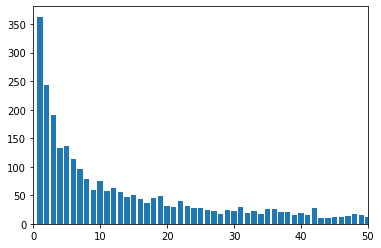

In [12]:
plt.bar(dd.groupby('count').count().index.to_array(), dd.groupby('count').count().to_array())
plt.xlim(0,50)

We can observe, that the observation count for some categories are 1. This means, that we have only one data point to calculate the average and *Target Encoding* overfits to these values. Therefore, we need to adjust the calculation:<br><li>if the number of observation is <b>high</b>, we want to use the <b>mean of this category value</b><br><li>if the number of observation is <b>low</b>, we want to use the <b>global mean</b>

\begin{equation} \label{eq:te}
TE_{target}([Categories]) = \frac{count([Categories]) * mean_{target}([Categories]) + w_{smoothing} * mean_{target}(global)}{count([Categories]) + w_{smoothing}}
\end{equation}

A simple way is to calculate a weighted average of the category value mean ($mean_{target}[Categories]$) and the global mean ($mean_{target}(global)$).

We add a smoothing weight $w_{smoothing} \in \mathbb{N}$. A bigger $w_{smoothing}$ relates to that *Target Encoding* is closer to the global mean.  

## Practice

Now, it is your turn. Let's try to implement *Target Encoding* as a function.<br><br>

**ToDo**:
<li>We use a smoothing factor of w=20<br>
<li>We Target Encode the columns feat=['brand', 'cat_2']

In [13]:
### ToDo

In [14]:
############### Solution ###############
feat = ['brand', 'cat_2']
w = 20

mean_global = df_train.target.mean()
te = df_train.groupby(feat)['target'].agg(['mean','count']).reset_index()
te['TE_brand_cat_2'] = ((te['mean']*te['count'])+(mean_global*w))/(te['count']+w)

df_train = df_train.merge(te, on=feat, how='left')
df_valid = df_valid.merge( te, on=feat, how='left' )
df_test = df_test.merge( te, on=feat, how='left' )
df_valid['TE_brand_cat_2'] = df_valid['TE_brand_cat_2'].fillna(mean_global)
df_test['TE_brand_cat_2'] = df_test['TE_brand_cat_2'].fillna(mean_global)

In [15]:
############### Solution End ###########

## Showing the effect of smoothing

A tree-based or deep learning based model cannot easily capture the idea of smoothing. We show the positive effect of smoothing on the target. Therefore, we compare *Target Encoding* with and without smoothing.

TargetEncoding without smoothing

In [16]:
cat = ['ts_weekday', 'ts_hour', 'cat_2', 'brand']
te = df_train.groupby(cat).target.agg(['mean', 'count']).reset_index()
te.columns = cat + ['TE_mean', 'TE_count']

In [17]:
df_valid = df_valid.merge(te, on=cat, how='left')
df_valid['error'] = (df_valid['target'] - (df_valid['TE_mean']>=0.5)).abs()

In [18]:
mean_global = df_train.target.mean()
df_valid['TE_mean'] = df_valid['TE_mean'].fillna(mean_global)

TargetEncoding with smoothing

In [19]:
w = 20
df_valid['TE_mean_smoothed'] = ((df_valid['TE_mean']*df_valid['TE_count'])+(mean_global*w))/(df_valid['TE_count']+w)
df_valid['TE_mean_smoothed'] = df_valid['TE_mean_smoothed'].fillna(mean_global)

In [20]:
df_valid['error_smoothed'] = (df_valid['target'] - (df_valid['TE_mean_smoothed']>=0.5)).abs()

Let's look at the error based on the number of observations. We can see, that the categorical values with low observation count (1, 2, 3) have a lower error rate with smoothing than without smoothing.

In [21]:
df_valid[['TE_count', 'error']].groupby('TE_count').error.mean()

TE_count
1        0.433183
2        0.487893
3        0.414957
4        0.461962
5        0.418925
           ...   
13672    0.477014
13789    0.516581
13806    0.484599
13847    0.469956
15033    0.328155
Name: error, Length: 2068, dtype: float64

In [22]:
df_valid[['TE_count', 'error_smoothed']].groupby('TE_count').error_smoothed.mean()

TE_count
1        0.330565
2        0.337878
3        0.340056
4        0.336385
5        0.344421
           ...   
13672    0.477014
13789    0.516581
13806    0.484599
13847    0.469956
15033    0.328155
Name: error_smoothed, Length: 2068, dtype: float64

We can look at the roc_auc values as well:

In [23]:
from sklearn.metrics import roc_auc_score

In [24]:
roc_auc_score(df_valid['target'].to_pandas().astype(int).values, 
              df_valid['TE_mean'].to_pandas().values)

0.57453584823663

In [25]:
roc_auc_score(df_valid['target'].to_pandas().astype(int).values, 
              df_valid['TE_mean_smoothed'].to_pandas().values)

0.5829179874937375

## Improve TargetEncoding with out-of-fold

We can still improve our *Target Encoding* function. We can even make it more generalizable, if we apply an *out of fold calculation*. <br><br>In our current definition, we use the full training dataset to *Target Encode* the training dataset and validation/test dataset. Therefore, we will likely overfit slightly on our training dataset, because we use the information from it to encode the categorical values. A better strategy is to use *out of fold*:
<li> use the full training dataset to encode the validation/test dataset<br>
<li> split the training dataset in k-folds and encode the i-th fold by using all folds except of the i-th one<br><br>
The following figure visualize the strategy for k=5:

<img src='../images/te_oof.png' width=50%>

The k-fold can be generated by a random split or by a timestamp depending on the dataset.

We restart the session.

In [26]:
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
!nvidia-smi

In [ ]:
import IPython

import pandas as pd
import cudf
import numpy as np
import cupy
import matplotlib.pyplot as plt

df_train = cudf.read_parquet('../data/train.parquet')
df_valid = cudf.read_parquet('../data/valid.parquet')
df_test = cudf.read_parquet('../data/test.parquet')

df_train['brand'] = df_train['brand'].fillna('UNKNOWN')
df_valid['brand'] = df_valid['brand'].fillna('UNKNOWN')
df_test['brand'] = df_test['brand'].fillna('UNKNOWN')
df_train['cat_2'] = df_train['cat_2'].fillna('UNKNOWN')
df_valid['cat_2'] = df_valid['cat_2'].fillna('UNKNOWN')
df_test['cat_2'] = df_test['cat_2'].fillna('UNKNOWN')

In [3]:
def target_encode(train, valid, col, target, kfold=5, smooth=20):
    """
        train:  train dataset
        valid:  validation dataset
        col:   column which will be encoded (in the example RESOURCE)
        target: target column which will be used to calculate the statistic
    """
    
    # We assume that the train dataset is shuffled
    train['kfold'] = ((train.index) % kfold)
    # We keep the original order as cudf merge will not preserve the original order
    train['org_sorting'] = cupy.arange(len(train), dtype="int32")
    # We create the output column, we fill with 0
    col_name = '_'.join(col)
    train['TE_' + col_name] = 0.
    for i in range(kfold):
        ###################################
        # filter for out of fold
        # calculate the mean/counts per group category
        # calculate the global mean for the oof
        # calculate the smoothed TE
        # merge it to the original dataframe
        ###################################
        
        df_tmp = train[train['kfold']!=i]
        mn = df_tmp[target].mean()
        df_tmp = df_tmp[col + [target]].groupby(col).agg(['mean', 'count']).reset_index()
        df_tmp.columns = col + ['mean', 'count']
        df_tmp['TE_tmp'] = ((df_tmp['mean']*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
        df_tmp_m = train[col + ['kfold', 'org_sorting', 'TE_' + col_name]].merge(df_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
        df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_' + col_name] = df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_tmp']
        train['TE_' + col_name] = df_tmp_m['TE_' + col_name].fillna(mn).values

    
    ###################################
    # calculate the mean/counts per group for the full training dataset
    # calculate the global mean
    # calculate the smoothed TE
    # merge it to the original dataframe
    # drop all temp columns
    ###################################    
    
    df_tmp = train[col + [target]].groupby(col).agg(['mean', 'count']).reset_index()
    mn = train[target].mean()
    df_tmp.columns = col + ['mean', 'count']
    df_tmp['TE_tmp'] = ((df_tmp['mean']*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
    valid['org_sorting'] = cupy.arange(len(valid), dtype="int32")
    df_tmp_m = valid[col + ['org_sorting']].merge(df_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
    valid['TE_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    
    valid = valid.drop('org_sorting', axis=1)
    train = train.drop('kfold', axis=1)
    train = train.drop('org_sorting', axis=1)
    return(train, valid)

In [4]:
%%time

df_train, df_valid = target_encode(df_train, df_valid, ['ts_weekday', 'ts_hour', 'cat_2', 'brand'], 'target')

CPU times: user 3.64 s, sys: 4.16 s, total: 7.8 s
Wall time: 7.56 s


In [5]:
df_train.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,cat_2,cat_3,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,TE_ts_weekday_ts_hour_cat_2_brand
0,2019-12-01 00:00:28 UTC,cart,17800342,zeta,66.90,550465671,22650a62-2d9c-4151-9f41-2674ec6d32d5,0,computers,desktop,UNKNOWN,<NA>,2019-12-01 00:00:28,0,0,6,1,12,2019,0.301241
1,2019-12-01 00:00:39 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,vacuum,<NA>,2019-12-01 00:00:39,0,0,6,1,12,2019,0.333539
2,2019-12-01 00:00:40 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,vacuum,<NA>,2019-12-01 00:00:40,0,0,6,1,12,2019,0.319065
3,2019-12-01 00:00:41 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,vacuum,<NA>,2019-12-01 00:00:41,0,0,6,1,12,2019,0.333539
4,2019-12-01 00:01:56 UTC,cart,1004767,samsung,235.60,579970209,c6946211-ce70-4228-95ce-fd7fccdde63c,0,construction,tools,light,<NA>,2019-12-01 00:01:56,0,1,6,1,12,2019,0.466269


In [6]:
df_valid.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,cat_2,cat_3,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,TE_ts_weekday_ts_hour_cat_2_brand
0,2020-03-01 00:00:59 UTC,cart,6902464,zlatek,49.91,531574188,48714293-b3f9-4946-8135-eb1ea05ead74,0,electronics,telephone,UNKNOWN,<NA>,2020-03-01 00:00:59,0,0,6,1,3,2020,0.366924
1,2020-03-01 00:01:20 UTC,cart,1002544,apple,397.10,622090790,fb5b918c-f1f6-48d9-bcf4-7eb46e83fc6b,0,construction,tools,light,<NA>,2020-03-01 00:01:20,0,1,6,1,3,2020,0.472616
2,2020-03-01 00:01:52 UTC,cart,1003316,apple,823.70,622090543,b821ee79-96fe-4979-be9d-21ee2e6777c3,0,construction,tools,light,<NA>,2020-03-01 00:01:52,0,1,6,1,3,2020,0.472616
3,2020-03-01 00:02:14 UTC,cart,16600067,rivertoys,422.15,616437533,aad023bc-c858-47ab-a3a7-ff4654f11b9a,0,sport,trainer,UNKNOWN,<NA>,2020-03-01 00:02:14,0,2,6,1,3,2020,0.333567
4,2020-03-01 00:02:15 UTC,cart,3701428,arnica,69.24,516454226,ee22b80c-ed3e-3c83-d397-fb69a44d4864,0,appliances,environment,vacuum,<NA>,2020-03-01 00:02:15,0,2,6,1,3,2020,0.379022


#### Summary

<li> Target Encoding calculates statistics of a target column given one or more categorical features<br>
<li> Target Encoding smooths the statistics as a weighted average of the category value and the global statistic<br>
<li> Target Encoding uses a out-of-fold strategy to prevent overfitting to the training dataset.<br><br>
    
We can see the advantage of using *Target Encoding* as a feature engineering step. A tree-based model or a neural network learns the average probability for the category value. However, neither model is designed to prevent overfitting. 

## Optimization

Let's compare the runtime between pandas and cuDF. The implementation depends only on the DataFrame object (calling function of the object) and does not require any pd / cuDF function. Therefore, we can use the same implementation and just use pandas.DataFrame and cuDF.DataFrame. 

We restart the session.

In [7]:
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
import IPython

import pandas as pd
import cudf
import numpy as np
import cupy
import matplotlib.pyplot as plt

df_train = cudf.read_parquet('../data/train.parquet')
df_valid = cudf.read_parquet('../data/valid.parquet')

df_train['brand'] = df_train['brand'].fillna('UNKNOWN')
df_valid['brand'] = df_valid['brand'].fillna('UNKNOWN')
df_train['cat_2'] = df_train['cat_2'].fillna('UNKNOWN')
df_valid['cat_2'] = df_valid['cat_2'].fillna('UNKNOWN')

In [2]:
def target_encode(train, valid, col, target, kfold=5, smooth=20, gpu=True):
    """
        train:  train dataset
        valid:  validation dataset
        col:   column which will be encoded (in the example RESOURCE)
        target: target column which will be used to calculate the statistic
    """
    
    # We assume that the train dataset is shuffled
    train['kfold'] = ((train.index) % kfold)
    # We keep the original order as cudf merge will not preserve the original order
    if gpu:
        train['org_sorting'] = cupy.arange(len(train), dtype="int32")
    else:
        train['org_sorting'] = np.arange(len(train), dtype="int32")
    # We create the output column, we fill with 0
    col_name = '_'.join(col)
    train['TE_' + col_name] = 0.
    for i in range(kfold):
        ###################################
        # filter for out of fold
        # calculate the mean/counts per group category
        # calculate the global mean for the oof
        # calculate the smoothed TE
        # merge it to the original dataframe
        ###################################
        
        df_tmp = train[train['kfold']!=i]
        mn = df_tmp[target].mean()
        df_tmp = df_tmp[col + [target]].groupby(col).agg(['mean', 'count']).reset_index()
        df_tmp.columns = col + ['mean', 'count']
        df_tmp['TE_tmp'] = ((df_tmp['mean']*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
        df_tmp_m = train[col + ['kfold', 'org_sorting', 'TE_' + col_name]].merge(df_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
        df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_' + col_name] = df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_tmp']
        train['TE_' + col_name] = df_tmp_m['TE_' + col_name].fillna(mn).values

    
    ###################################
    # calculate the mean/counts per group for the full training dataset
    # calculate the global mean
    # calculate the smoothed TE
    # merge it to the original dataframe
    # drop all temp columns
    ###################################    
    
    df_tmp = train[col + [target]].groupby(col).agg(['mean', 'count']).reset_index()
    mn = train[target].mean()
    df_tmp.columns = col + ['mean', 'count']
    df_tmp['TE_tmp'] = ((df_tmp['mean']*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
    if gpu:
        valid['org_sorting'] = cupy.arange(len(valid), dtype="int32")
    else:
        valid['org_sorting'] = np.arange(len(valid), dtype="int32")
    df_tmp_m = valid[col + ['org_sorting']].merge(df_tmp, how='left', left_on=col, right_on=col).sort_values('org_sorting')
    valid['TE_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    
    valid = valid.drop('org_sorting', axis=1)
    train = train.drop('kfold', axis=1)
    train = train.drop('org_sorting', axis=1)
    return(train, valid)

In [3]:
df_train_pd = df_train.to_pandas()
df_valid_pd = df_valid.to_pandas()

In [4]:
%%time

df_train_pd, df_valid_pd = target_encode(df_train_pd, df_valid_pd, ['ts_weekday', 'ts_hour', 'cat_2', 'brand'], 'target', gpu=False)

CPU times: user 44.3 s, sys: 23.8 s, total: 1min 8s
Wall time: 1min 8s


In [5]:
%%time

df_train, df_valid = target_encode(df_train, df_valid, ['ts_weekday', 'ts_hour', 'cat_2', 'brand'], 'target')

CPU times: user 3.77 s, sys: 4.04 s, total: 7.81 s
Wall time: 7.56 s


In our experiments, we achieve a speed up of 11.6x.

Our implementation can be still improved. We will show a further optimized solution based on dask and dask_cudf.

We shutdown the kernel.

In [6]:
app = IPython.Application.instance()
app.kernel.do_shutdown(False)

{'status': 'ok', 'restart': False}